In [19]:
import geojson
import numpy as np
from mmap import MAP_ANONYMOUS
import folium
from shapely.geometry import LineString, Point
from shapely.ops import transform
import pyproj
from math import ceil
import random
import matplotlib.pyplot as plt

In [4]:
with open('lijnsecties-1.json', 'r') as f:
    data = geojson.load(f)

In [5]:
trajectories_size=[len(np.array(data['features'][i]['geometry']['coordinates'])) for i in range(len(data['features']))]
print(np.argmax(trajectories_size),np.max(trajectories_size))

360 908


In [39]:
line = np.array(data['features'][360]['geometry']['coordinates'])
line[:,[0,1]]=line[:,[1,0]]
map_center=line[400,:]
mapa = folium.Map(location=map_center, zoom_start=13, width=1600/2, height=900/2)
folium.PolyLine(locations=line, color='red', weight=3).add_to(mapa)

In [40]:
np.savetxt('line_BEL_360.txt', line, delimiter=',', comments='',fmt='%.7f')
print("Datos guardados en 'line_BEL_360.txt'")

Datos guardados en 'line_BEL_360.txt'


In [41]:
index_sample=random.randint(0,line.shape[0])
err_x=0.05*(np.max(line[:,0])-np.min(line[:,0]))
err_y=0.05*(np.max(line[:,1])-np.min(line[:,1]))
new_point=(line[index_sample,0]+random.choice([1, -1])*err_x,line[index_sample,1]+random.choice([1, -1])*err_y)
print(new_point)
folium.Marker(location=new_point, popup=f"GNSS output").add_to(mapa)

(np.float64(51.1002386), np.float64(3.3885940000000003))


In [42]:
display(mapa)

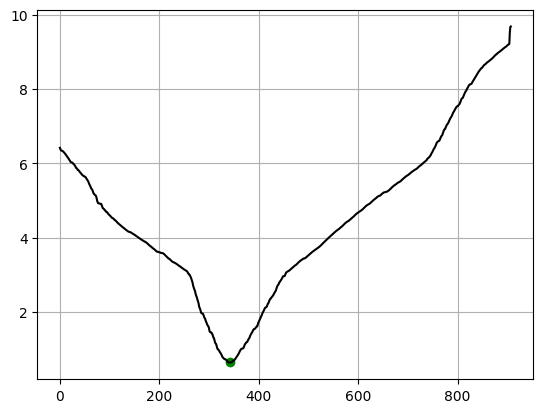

In [43]:
def haversine(coord1, coord2):
    # Convierte las coordenadas de grados a radianes
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2[:, 0]), np.radians(coord2[:, 1])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radio de la Tierra en kilómetros: 6371
    km = 6371 * c
    return km

distances = haversine(new_point, line)

closest_index = np.argmin(distances)
closest_point = line[closest_index,:]
plt.plot(distances,color="black")
plt.scatter(closest_index,np.min(distances),color='green')
plt.grid(True)
plt.show()

folium.Marker(location=closest_point, popup=f"Closest Point (I)",icon=folium.Icon(color='green')).add_to(mapa)
mapa